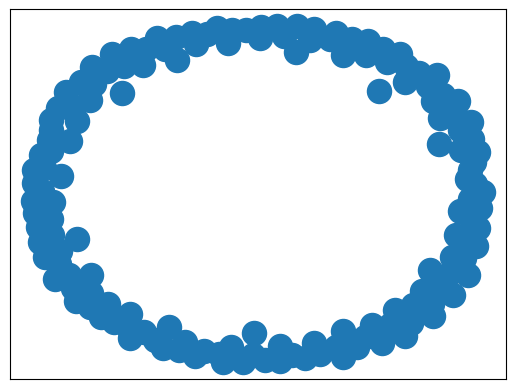

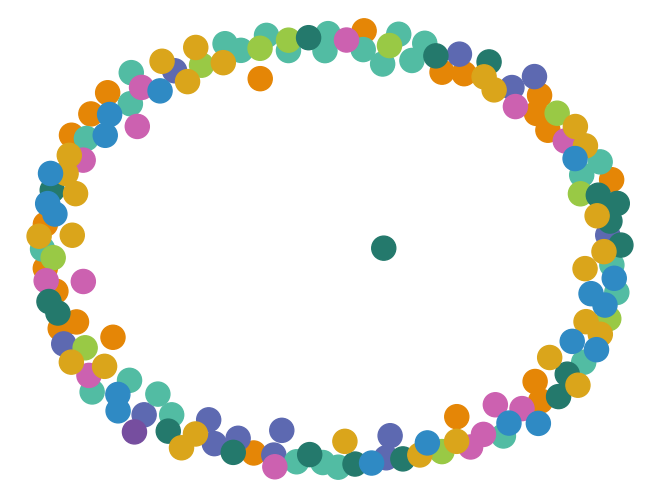

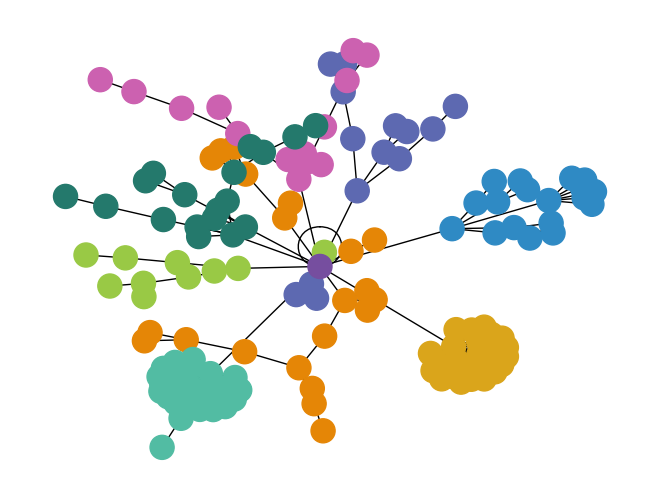

Coercing column 'status' to `list`
Coercing column 'languages' to `list`
Coercing column 'status' to `list`
Coercing column 'languages' to `list`


In [32]:
%run "../Part 1 - The Graph/Solution.ipynb"

Now we can take extra info (attributes) of each person (node) and map those onto nodes. This will allow us to connect people *through* common attributes, and not just through relationships like "reporting structure" or "hierarchy"

In [33]:
from itertools import chain
from more_itertools import always_iterable

def add_nodes_from_attributes(G: nx.Graph, *, attribute:str, default=[], flag:str):
    attributes = {person:attribute for person, attribute in G.nodes(data=attribute, default=default) if attribute}
    print(attributes)
    for attr in set(chain.from_iterable((always_iterable(value) for value in attributes.values()))):
        if attr:
            G.add_node(attr, **{flag: True, "type":flag})
        
add_nodes_from_attributes(G, attribute="languages", flag="language")
#add_nodes_from_attributes(G, attribute="apps", flag="app")
add_nodes_from_attributes(G, attribute="tz", flag="timezone", default="")

{'Caitlin Maldonado': {'Python', 'JavaScript'}, 'John Alvarado': {'Go', 'Java'}, 'Jeremy Daniel': {'Python', 'JavaScript', 'Java'}, 'Joshua Gibson': {'Scala', 'Go', 'Java', 'Typescript'}, 'Randy Newman': {'JavaScript', 'Go'}, 'Monique Ray': {'JavaScript', 'Java'}, 'Robert Lara': {'Java', 'Typescript'}, 'Alan Gonzalez': {'Java', 'Scala'}, 'Anthony Moreno': {'Python'}, 'Benjamin Sharp': {'JavaScript', 'Go', 'Scala'}, 'Danielle Macias': {'Python', 'Go'}, 'Samantha Henderson': {'JavaScript', 'Java', 'Scala'}, 'Dr. Amy Butler': {'JavaScript', 'Java', 'Typescript'}, 'Joseph Harris Jr.': {'Python', 'Java', 'Typescript'}, 'Tiffany Foster': {'Python', 'JavaScript', 'Java', 'Scala'}, 'Bruce Rollins': {'Go'}, 'Deborah Ramos': {'Scala', 'JavaScript', 'Python', 'Java', 'Typescript'}, 'Lauren Wright': {'Python', 'JavaScript', 'Java', 'Typescript'}, 'John Jones': {'JavaScript', 'Typescript'}, 'Carlos Reynolds': {'Java', 'Typescript'}, 'Todd Peters': {'Go', 'Python', 'Java'}, 'Kelly Christensen': {'Py

Let's add the edges in now connecting people to the app/language nodes!

In [34]:
from more_itertools import always_iterable

def just_people(G):
    return lambda n: G.nodes()[n].get("person")

def add_edges_from_attributes(G:nx.Graph, *, attribute:str, weight:int=1):
    nodes = G.nodes()
    for name, attributes in nx.subgraph_view(G, filter_node=just_people(G)).nodes(data=attribute):
        for attr in always_iterable(attributes):
            if attr in nodes:
                G.add_edge(name, attr, weight=weight, **{attribute:True})

In [35]:
add_edges_from_attributes(G, attribute="languages")
add_edges_from_attributes(G, attribute="tz")
#add_edges_from_attributes(G, attribute="apps")
#add_edges_from_attributes(G, attribute="manager")

This should look interesting! We used a **force-directed layout** to draw the graph, meaning that the edges between nodes are **pulling** the nodes together in order until they find an equilibrium point. This also takes into account the weights we applied to edges, with higher weighed edges behaving like springs with higher spring constants

In [9]:
px_plot_nx(G, height=800, hover_name="label", color="team", size="rank", with_edges=True, template="plotly_dark")

Coercing column 'status' to `list`
Coercing column 'languages' to `list`


## Extras

For the sake of the tutorial we are going to continue with a visual exploration of the graph, but we can also use computational methods. Here are a few jumping off points:

Let's use a few methods to investigate how the *people* nodes in the graph are connected and see if we can find clusters and *neighbourhoods*

We can look at just a "neighbourhood" around a person ... but this is currently unweighted, so we're just seeing anything 1 node away, instead of looking at a more complete view of "closeness"

In [36]:
someone = list(G.nodes)[0]

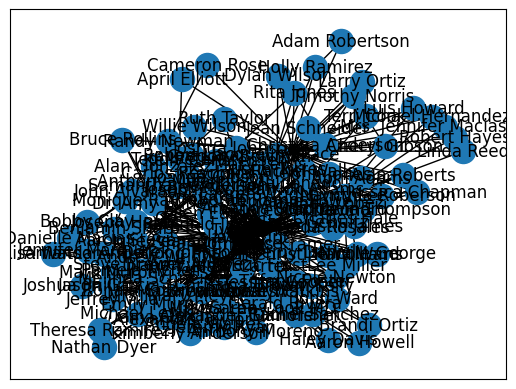

In [37]:
ego = nx.ego_graph(G, someone, undirected=True, radius=2)
ego_people = nx.subgraph_view(ego, filter_node=just_people(G)).nodes()
nx.draw_networkx(ego, nodelist=ego_people)

This information is also easy to recover frbom the Graph itself

In [45]:
peoplenodes = nx.subgraph_view(ego, filter_node=just_people)

In [47]:
connectivity = nx.all_pairs_node_connectivity(ego, nbunch=peoplenodes)
connectivity

{'Mary Lewis': {'Python': 5,
  'Ryan Kelly': 5,
  'Kimberly Anderson': 4,
  'Nancy Lee': 5,
  'Alexander Gilmore': 5,
  'Todd Peters': 5,
  'Michael Lewis': 4,
  'Bobby Clay': 4,
  'Mark Murphy': 5,
  'Mrs. Sarah Cook MD': 5,
  'Robin Lynch': 5,
  'UTC': 5,
  'Jacqueline Pace': 5,
  'Nicole George': 3,
  'Jeffrey Villa': 5,
  'Nicole Newton': 5,
  'Pamela Mcneil': 5,
  'Robert Hayes': 2,
  'Eric Frost': 4,
  'Gerald Rivera': 4,
  'Amanda Lopez': 5,
  'Steve Brewer': 5,
  'Go': 5,
  'John Jones': 5,
  'Zachary Allen': 5,
  'April Adams': 4,
  'Rachel Sanchez': 4,
  'Benjamin Sharp': 5,
  'Linda Reed': 2,
  'Kara Ward': 4,
  'JavaScript': 5,
  'Aaron Howell': 2,
  'Denise Watkins': 5,
  'Anthony Moreno': 4,
  'Jean Schneider': 3,
  'Lisa Lee': 4,
  'April Elliott': 2,
  'Christina Anderson': 4,
  'Brandi Ortiz': 2,
  'Patrick Adams': 5,
  'Cameron Rose': 2,
  'Stephanie Thompson': 5,
  'Joseph Cooper': 5,
  'EST': 5,
  'Timothy Norris': 2,
  'Bryan Spears': 5,
  'Scala': 5,
  'Amanda Arm

We can also look at where nodes get placed in our force-directed graph and look for closeness there

```python
import numpy as np
import xarray as xr

positions = {
    name: pos for name, pos in nx.spring_layout(G).items() if name in peoplenodes
}
positions = xr.DataArray(
    list(positions.values()),
    coords={"person": list(positions), "position": ["x", "y"]},
    dims=["person", "position"],
    attrs=dict(description="Node locations in a force-directed layout"),
)
positions
```

We can now do some matrix math to find the pairwise euclidean distances between each node!

```python
similarities = np.sqrt(((positions - positions.rename(person="person2"))**2).sum("position"))
similarities.name = "distance"
similarities
```

```python
friends = similarities.sel(person="Lucas").sortby(similarities.sel(person="Lucas"))
friends[:2].person2
```

But this is the same approach (in spirit) to representing a graph as vectors in N-dimensional space (only here we do just 2-dim). A more common approach is to use `node2vec` and then look for closeness in the vectors